<a href="https://colab.research.google.com/github/FrankJRix/ProgettoML/blob/main/Progetto1_SRS_franco_risi_1620118.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import pandas as pd
import matplotlib.pyplot as plt
import os

In [99]:
# def funzioni 

def comparison_plot(vectors, cols, figsize=(0,0), labels=[]):
    rows = len(vectors)
    if figsize == (0,0):
        figsize = (cols*6,rows*3)

    figure = plt.figure(figsize=figsize)
    for i in range(1, cols + 1):
        sample_idx = torch.randint(len(vectors[0]), size=(1,)).item()

        for j in range(len(vectors)):
            img = vectors[j][sample_idx].squeeze()
            figure.add_subplot(rows, cols, i+j*cols)
            plt.title(f'sample #{sample_idx}')
            if labels and len(labels) == len(vectors):
                plt.ylabel(labels[j])
            plt.plot(range(len(img)), img)

    plt.show()

def PSNR(I, K, max_v):
    I = I.cpu().detach().numpy().squeeze()
    K = K.cpu().detach().numpy().squeeze()
    return 10 * np.log10(max_v**2 / np.square(np.subtract(I, K)).mean())

In [100]:
print('Downloading datasets')
if not os.path.exists('raman_sim_data.npz'):
    os.system('wget http://giagu.web.cern.ch/giagu/CERN/raman_sim_data.npz')
print('Done')

Done


['X_train', 'Y_train', 'X_test', 'Y_test', 'arr_0', 'arr_1', 'arr_2', 'arr_3']
(8000, 400, 1)
(8000, 400, 1)
(2000, 400, 1)
(2000, 400, 1)
(8000, 400, 1)
(2000, 400, 1)
(400, 1)
max = 0.9283096703893785


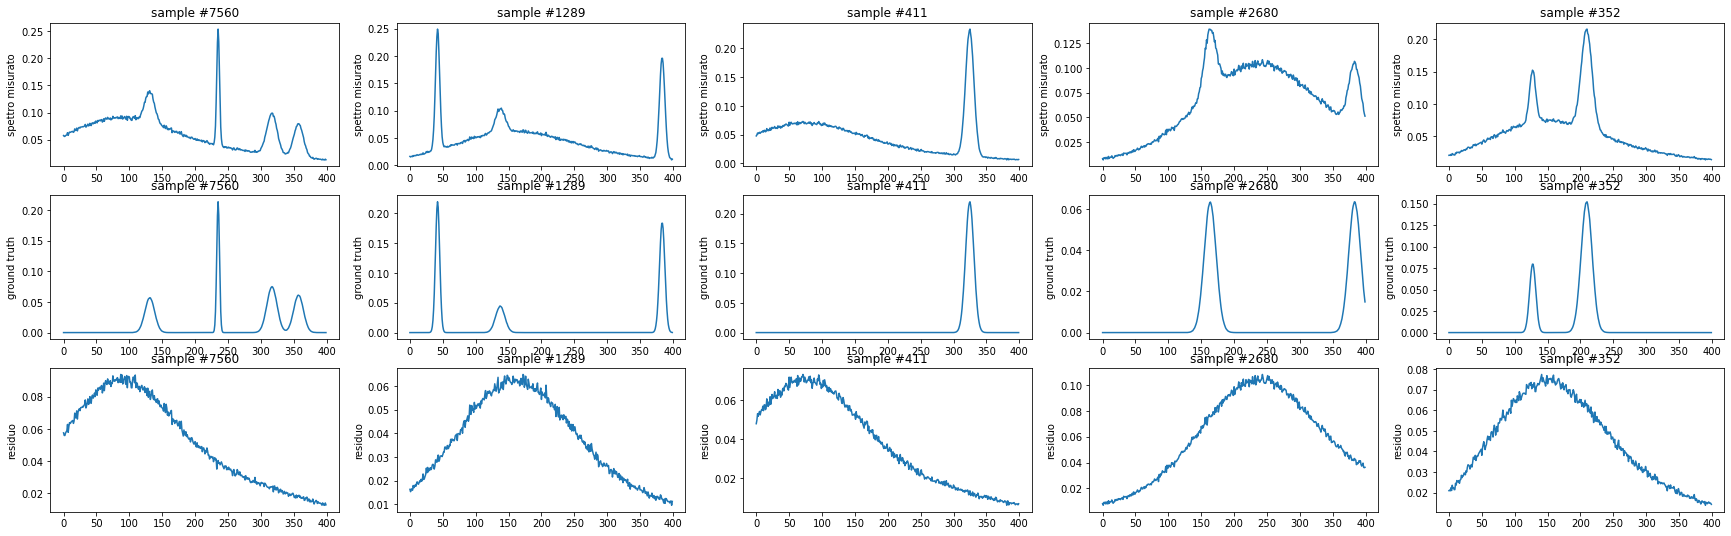

In [101]:
file = np.load('raman_sim_data.npz')
print(file.files)

X_train = file['X_train']#.squeeze()
Y_train = file['Y_train']#.squeeze()
X_test = file['X_test']#.squeeze()
Y_test = file['Y_test']#.squeeze()
res_train = X_train - Y_train
res_test = X_test - Y_test

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(res_train.shape)
print(res_test.shape)

print(X_train[0].shape)

max_value = max(Y_train.max(), Y_test.max())

print(f"max = {max_value}")

comparison_plot((X_train, Y_train, res_train), 5, labels=["spettro misurato","ground truth","residuo"])

In [102]:
if torch.cuda.is_available():
  print('Numero di GPU disponibili: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(0))

# se la GPU è disponibile setto device='cuda', altrimenti 'cpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Numero di GPU disponibili:  1
Tesla T4
Computation device: cuda



In [103]:
class myDS(Dataset):
    def __init__(self, data, target, transforms=None):
        self.data = data
        self.target = target
        self.transforms = transforms

    def __getitem__(self, index):
        img = self.data[index].reshape((1,400))
        img = np.float32(img)
        target = self.target[index].reshape((1,400))
        target = np.float32(target)
        if self.transforms:
            img = self.transforms(img)
        return (img, target)

    def __len__(self):
        return len(self.data)

In [104]:
train_transforms = transforms.Compose([
                                       #transforms.ToTensor(),
                                      ])

test_transforms = test_transforms = transforms.Compose([
                                       #transforms.ToTensor(),
                                      ])

train_dataset = myDS(X_train, res_train, train_transforms)
tv_dataset = myDS(X_test, res_test, test_transforms)
test_dataset, vali_dataset = torch.utils.data.random_split(tv_dataset, [1000, 1000])

print('Trainign set size: ', len(train_dataset))
print('Validation set size: ',len(vali_dataset))
print('Test set size: ',len(test_dataset))

batch_size = 500
dataloaders = dict()
dataloaders['train'] = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloaders['vali'] = torch.utils.data.DataLoader(vali_dataset, batch_size=batch_size, shuffle=True)
dataloaders['test'] = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Trainign set size:  8000
Validation set size:  1000
Test set size:  1000


In [105]:
kernel_size = 7
padding = (kernel_size - 1)/2
padding = int(padding)
out_channels = 32

print(padding)

class my1DnCNN(nn.Module):
    def __init__(self):
        super(my1DnCNN, self).__init__()

        # definizione dei layers

        # primo blocco convoluzionale
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=out_channels, kernel_size=(kernel_size), padding=padding)

        self.conv2 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=(kernel_size), padding=padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=(kernel_size), padding=padding)
        self.bn3 = nn.BatchNorm1d(out_channels)
        self.conv4 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=(kernel_size), padding=padding)
        self.bn4 = nn.BatchNorm1d(out_channels)
        self.conv5 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=(kernel_size), padding=padding)
        self.bn5 = nn.BatchNorm1d(out_channels)
        self.conv6 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=(kernel_size), padding=padding)
        self.bn6 = nn.BatchNorm1d(out_channels)
        self.conv7 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=(kernel_size), padding=padding)
        self.bn7 = nn.BatchNorm1d(out_channels)
        self.conv8 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=(kernel_size), padding=padding)
        self.bn8 = nn.BatchNorm1d(out_channels)
        self.conv9 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=(kernel_size), padding=padding)
        self.bn9 = nn.BatchNorm1d(out_channels)
        self.conv10 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=(kernel_size), padding=padding)
        self.bn10 = nn.BatchNorm1d(out_channels)
        self.conv11 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=(kernel_size), padding=padding)
        self.bn11 = nn.BatchNorm1d(out_channels)
        self.conv12 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=(kernel_size), padding=padding)
        self.bn12 = nn.BatchNorm1d(out_channels)
        self.conv13 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=(kernel_size), padding=padding)
        self.bn13 = nn.BatchNorm1d(out_channels)
        self.conv14 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=(kernel_size), padding=padding)
        self.bn14 = nn.BatchNorm1d(out_channels)
        self.conv15 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=(kernel_size), padding=padding)
        self.bn15 = nn.BatchNorm1d(out_channels)
        self.conv16 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=(kernel_size), padding=padding)
        self.bn16 = nn.BatchNorm1d(out_channels)
        self.conv17 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=(kernel_size), padding=padding)
        self.bn17 = nn.BatchNorm1d(out_channels)
        self.conv18 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=(kernel_size), padding=padding)
        self.bn18 = nn.BatchNorm1d(out_channels)
        self.conv19 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=(kernel_size), padding=padding)
        self.bn19 = nn.BatchNorm1d(out_channels)
        self.conv20 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=(kernel_size), padding=padding)
        self.bn20 = nn.BatchNorm1d(out_channels)

        self.out_conv = nn.Conv1d(in_channels=out_channels, out_channels=1, kernel_size=(kernel_size), padding=padding)

        self.drop1 = nn.Dropout(p=0.3) #dropout 
        self.fc1 = nn.Linear(in_features=400, out_features=800)
        self.drop2 = nn.Dropout(p=0.3) #dropout 
        self.fc2 = nn.Linear(in_features=800, out_features=200)
        self.fc3 = nn.Linear(in_features=200, out_features=400)

  # forward pass: x (input) -> out  
    def forward(self, x):
        x = F.relu(self.conv1(x))

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = F.relu(self.bn9(self.conv9(x)))
        x = F.relu(self.bn10(self.conv10(x)))
        x = F.relu(self.bn11(self.conv11(x)))
        x = F.relu(self.bn12(self.conv12(x)))
        x = F.relu(self.bn13(self.conv13(x)))
        x = F.relu(self.bn14(self.conv14(x)))
        x = F.relu(self.bn15(self.conv15(x)))
        x = F.relu(self.bn16(self.conv16(x)))
        x = F.relu(self.bn17(self.conv17(x)))
        x = F.relu(self.bn18(self.conv18(x)))
        x = F.relu(self.bn19(self.conv19(x)))
        x = F.relu(self.bn20(self.conv20(x)))

        x = self.out_conv(x)

        #x = self.drop1(x)
        x = F.relu(self.fc1(x))
        #x = self.drop2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        out = x
        return out

model = my1DnCNN()
print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,400))
else:
  summary(model, input_size=(1,400))

# loss function, accuracy, optimzer

# loss function 
loss_func = nn.MSELoss()
metric_func = nn.L1Loss()

# ottmizzatore
from torch import optim
LR_ST = 1e-3
opt = optim.Adam(model.parameters(), lr=LR_ST)

# scheduler
scheduler = optim.lr_scheduler.StepLR(opt, 12, gamma=0.6, last_epoch=-1, verbose=True)

3
my1DnCNN(
  (conv1): Conv1d(1, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(32, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(32, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(32, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(32, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv1d(32, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv1d(32, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn7): BatchNorm1d(32, eps=1e-05, momentum=0.

In [106]:
#Checkpoint per salvare il modello durante il training (solo il best model)
class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion, metric,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that 
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({'model' : model,
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'metric': metric,
                }, 'best_model.pt')

In [107]:
# Training loop

model.to(device)
save_best_model = SaveBestModel()

import time

# numero di epoche
epochs = 60

# liste su cui salvare il valore della loss e della metrica ad ogni epoca per poterli graficare in funzione 
# dell'epoca a fine addestramento
hist_loss = []
hist_metric = []
hist_psnr = []
hist_vloss = []
hist_vmetric = []
hist_vpsnr = []

# loop sulle epoche
for epoch in range(epochs):
    t0 = time.time()
    
    # training step (in cui aggiorniamo i pesi della rete neurale)
    model.train()
    train_loss = 0
    train_metric = 0
    train_psnr = 0
    counter = 0

    for xb, yb in dataloaders['train']:
        counter += 1
        xb=xb.to(device) #copio il mini batch di dati sulla CPU/GPU
        yb=yb.to(device) #copio il mini batch di label sulla CPU/GPU

        pred = model(xb) #predizione del modello

        # calcolo loss e metrica
        loss = loss_func(pred, yb)
        metric = metric_func(pred, yb)
        psnr = PSNR(xb-yb, xb-pred, max_value)

        # aggiorno la loss e metrica totale
        train_loss += loss.item()
        train_metric += metric.item()
        train_psnr += psnr.item()

        # backpropagation
        opt.zero_grad() #resetta i gradienti prima di eseguire la backpropagation
        loss.backward() #calcola i gradeinti della loss
        opt.step() #aggiorna i pesi

    train_loss /= counter
    train_metric /= counter
    train_psnr /= counter
    hist_loss.append(train_loss)
    hist_metric.append(train_metric)
    hist_psnr.append(train_psnr)

    # validation step (non vengono aggiornati i pesi)
    model.eval()
    vali_loss = 0
    vali_metric = 0
    vali_psnr = 0
    counter = 0

    with torch.no_grad(): #evita che si aggiornino i pesi
        for xb, yb in dataloaders['vali']:
            counter += 1
            xb=xb.to(device)
            yb=yb.to(device)

            pred = model(xb) #predizione del modello

            # calcolo loss e metrica
            vloss = loss_func(pred, yb)
            vmetric = metric_func(pred, yb)
            vpsnr = PSNR(xb-yb, xb-pred, max_value)
            vali_loss += vloss.item()
            vali_metric += vmetric.item()
            vali_psnr += vpsnr.item()

    vali_loss /= counter
    vali_metric /= counter
    vali_psnr /= counter
    hist_vloss.append(vali_loss)
    hist_vmetric.append(vali_metric)
    hist_vpsnr.append(vali_psnr)

    #save best model
    save_best_model(vali_loss, epoch, model, opt, loss_func, metric_func)   

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, train PSNR: %.6f, vali loss: %.6f, vali metric: %.6f, vali PSNR: %.6f" 
            % (epoch+1, elapsed_time, train_loss, train_metric, train_psnr, vali_loss, vali_metric, vali_psnr))
    
    # update learning rate schedule
    scheduler.step()


Best validation loss: 0.002185643883422017

Saving best model for epoch: 1

epoch: 1, time(s): 2.1297, train loss: 0.001763, train metric: 0.030965, train PSNR: 28.262342, vali loss: 0.002186, vali metric: 0.037743, vali PSNR: 25.958089
Adjusting learning rate of group 0 to 1.0000e-03.

Best validation loss: 0.0014805206446908414

Saving best model for epoch: 2

epoch: 2, time(s): 2.0583, train loss: 0.000378, train metric: 0.015300, train PSNR: 33.681064, vali loss: 0.001481, vali metric: 0.030760, vali PSNR: 27.650018
Adjusting learning rate of group 0 to 1.0000e-03.

Best validation loss: 0.00081915597547777

Saving best model for epoch: 3

epoch: 3, time(s): 2.0615, train loss: 0.000166, train metric: 0.010009, train PSNR: 37.298965, vali loss: 0.000819, vali metric: 0.022695, vali PSNR: 30.220192
Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 4, time(s): 2.0052, train loss: 0.000080, train metric: 0.007023, train PSNR: 40.408632, vali loss: 0.000966, vali metric: 0.0249

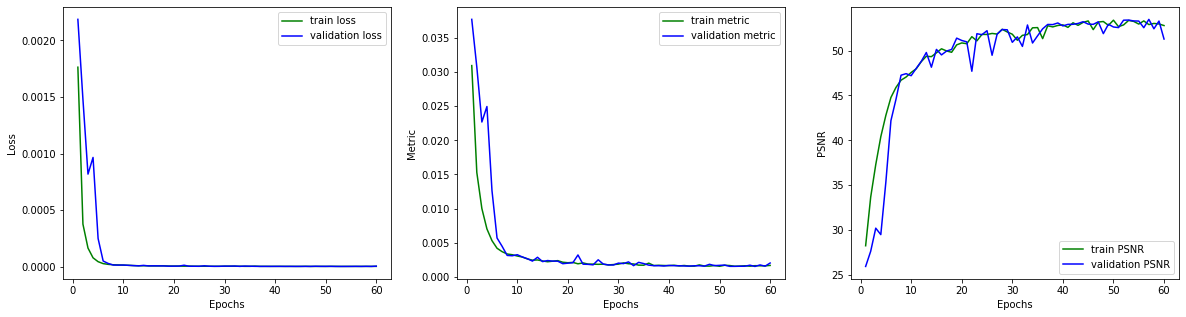

In [108]:
# grafico monitoring training
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,3,2)
plt.plot(range(1,len(hist_metric)+1),hist_metric, color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()

plt.subplot(1,3,3)
plt.plot(range(1,len(hist_psnr)+1),hist_psnr, color='green', linestyle='-', label='train PSNR')
plt.plot(range(1,len(hist_vpsnr)+1),hist_vpsnr, color='blue', linestyle='-', label='validation PSNR')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()
plt.show()

In [109]:
# test set perfromance

# lettura del modello
model_data = torch.load('./best_model.pt')
print('Best model at epoch: ', model_data['epoch'])
model = model_data['model']
model.eval() 

model.to(torch.device('cpu'))

loss = 0
metric = 0
psnr = 0
counter = 0
inputs = []
predictions = []
truth = []

for xb, yb in dataloaders['test']:
    counter += 1
    xb=xb.to('cpu')
    yb=yb.to('cpu')
    pred = model(xb)
    input_np = xb.detach().numpy()
    pred_np = pred.detach().numpy()
    yy = yb.detach().numpy()

    for elem in input_np:
        inputs.append(elem)
    for elem in pred_np:
        predictions.append(elem)
    for elem in yy:
        truth.append(elem)

    loss += loss_func(pred, yb).item()
    metric += metric_func(pred, yb).item()
    psnr += PSNR(xb-yb, xb-pred, max_value)

print(inputs[0].shape)
print(truth[0].shape)
print(predictions[0].shape)

loss /= counter
metric /= counter
psnr /= counter

print('Test loss/metric: ',loss, ' / ', metric)
print('Test PSNR: ', psnr)

Best model at epoch:  57
(1, 400)
(1, 400)
(1, 400)
Test loss/metric:  3.8476281360999565e-06  /  0.0015144844073802233
Test PSNR:  53.502471579849896


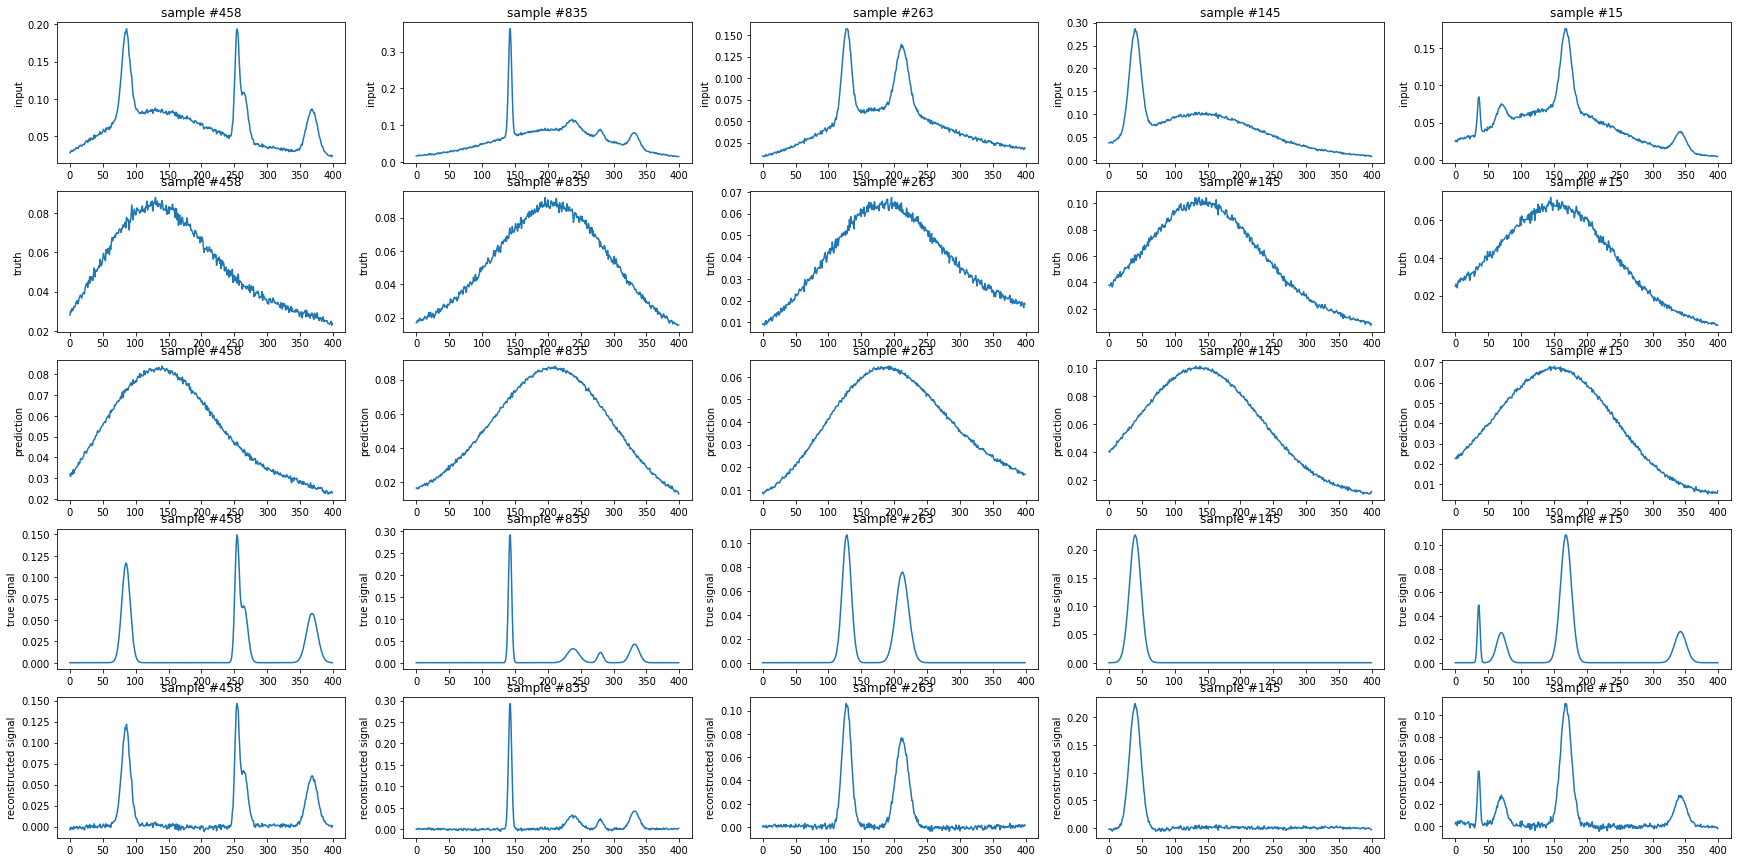

In [110]:
true_signal = np.array(inputs) - np.array(truth)
reconstructed_signal = np.array(inputs) - np.array(predictions)

comparison_plot((inputs, truth, predictions, true_signal, reconstructed_signal), 5, labels=["input","truth","prediction","true signal","reconstructed signal"])